In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from glob import glob
import zipfile
from tqdm import tqdm
import cv2
from tensorflow.keras.utils import Sequence

2025-06-16 21:25:11.888141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750109112.083135      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750109112.143325      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def gaussian_kernel_discrete(sigma=15):
    kernel_radius = int(2.5 * sigma)
    size = 2 * kernel_radius + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

def generate_density_map(image_shape, points, sigma=15):
    h, w = image_shape
    density_map = np.zeros((h, w), dtype=np.float32)
    kernel = gaussian_kernel_discrete(sigma)
    kH, kW = kernel.shape
    kH2, kW2 = kH // 2, kW // 2

    for point in points:
        x = min(w - 1, max(0, int(point[0])))
        y = min(h - 1, max(0, int(point[1])))

        x1 = max(0, x - kW2)
        x2 = min(w, x + kW2 + 1)
        y1 = max(0, y - kH2)
        y2 = min(h, y + kH2 + 1)

        kx1 = kW2 - (x - x1)
        kx2 = kW2 + (x2 - x)
        ky1 = kH2 - (y - y1)
        ky2 = kH2 + (y2 - y)

        density_map[y1:y2, x1:x2] += kernel[ky1:ky2, kx1:kx2]

    return density_map

def load_points_from_mat(mat_file):
    mat = sio.loadmat(mat_file)
    try:
        points = mat['image_info'][0, 0][0, 0][0]
    except:
        raise ValueError("Check the internal structure of your .mat file.")
    return points

Image: IMG_1.jpg
→ Number of people (points): 234
→ Sum of density map: 210.57



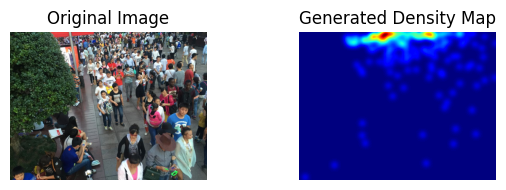

Image: IMG_10.jpg
→ Number of people (points): 230
→ Sum of density map: 207.34



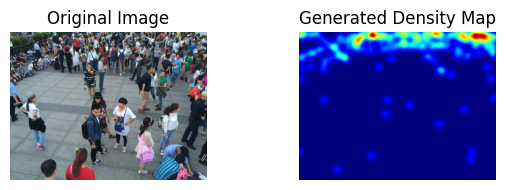

Image: IMG_100.jpg
→ Number of people (points): 206
→ Sum of density map: 203.86



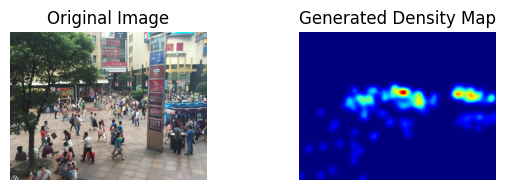

Image: IMG_101.jpg
→ Number of people (points): 83
→ Sum of density map: 80.14



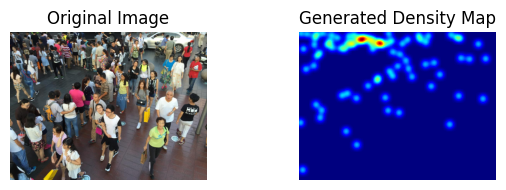

In [5]:
image_dir = '/kaggle/input/crowd-data/crowd dataset/train_data/images'
mat_dir = '/kaggle/input/crowd-data/crowd dataset/train_data/ground_truth'

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])[:4]

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    mat_path = os.path.join(mat_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_shape = img.shape[:2]  # (height, width)

    points = load_points_from_mat(mat_path)
    density_map = generate_density_map(img_shape, points, sigma=15)

    print(f"Image: {img_file}")
    print(f"→ Number of people (points): {len(points)}")
    print(f"→ Sum of density map: {density_map.sum():.2f}\n")

    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(density_map, cmap='jet')
    plt.title('Generated Density Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
input_dir = '/kaggle/input/crowd-data/crowd dataset/train_data/ground_truth'
output_dir = '/kaggle/working/ground_truth_density_map'
os.makedirs(output_dir, exist_ok=True)

image_shape = (768, 1024)

mat_files = [f for f in os.listdir(input_dir) if f.endswith('.mat')]

for file in tqdm(mat_files, desc="Generating density maps"):
    mat_path = os.path.join(input_dir, file)
    points = load_points_from_mat(mat_path)
    density_map = generate_density_map(image_shape, points, sigma=15)

    output_path = os.path.join(output_dir, file.replace('.mat', '.npy'))
    np.save(output_path, density_map)

Generating density maps: 100%|██████████| 400/400 [00:04<00:00, 82.74it/s]


In [12]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

class ImageDensityMapGenerator(Sequence):
    def __init__(self, image_dir, density_dir, image_size=(768, 1024), batch_size=4, shuffle=True):
        self.image_dir = image_dir
        self.density_dir = density_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.image_filenames = sorted([
            fname for fname in os.listdir(image_dir) if fname.endswith('.jpg')
        ])
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_density_maps = []

        for fname in batch_filenames:
            img_path = os.path.join(self.image_dir, fname)
            img = cv2.imread(img_path)  # Loads in BGR by default
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (self.image_size[1], self.image_size[0]))  # Resize to (W, H)

            density_fname = 'GT_' + fname.replace('.jpg', '.npy')
            density_path = os.path.join(self.density_dir, density_fname)
            density_map = np.load(density_path).astype(np.float32)
            density_map = density_map[..., np.newaxis]  # Add channel dimension

            batch_images.append(img)
            batch_density_maps.append(density_map)

        return np.array(batch_images), np.array(batch_density_maps)


In [13]:
train_gen = ImageDensityMapGenerator(
    image_dir='/kaggle/input/crowd-data/crowd dataset/train_data/images',
    density_dir='/kaggle/working/ground_truth_density_map',
    image_size=(768, 1024),
    batch_size=4,
    shuffle=True)

total_size = len(train_gen.image_filenames)
train_size = int(0.9 * total_size)
val_filenames = train_gen.image_filenames[train_size:]
train_filenames = train_gen.image_filenames[:train_size]

train_gen.image_filenames = train_filenames
val_gen = ImageDensityMapGenerator(
    image_dir=train_gen.image_dir,
    density_dir=train_gen.density_dir,
    image_size=train_gen.image_size,
    batch_size=train_gen.batch_size,
    shuffle=False)

val_gen.image_filenames = val_filenames

In [14]:

images, density_maps = train_gen[0]

print("Input image batch shape:", images.shape)
print("Single input image shape:", images[0].shape)

print("Density map batch shape:", density_maps.shape)
print("Single density map shape:", density_maps[0].shape)


Input image batch shape: (4, 768, 1024, 3)
Single input image shape: (768, 1024, 3)
Density map batch shape: (4, 768, 1024, 1)
Single density map shape: (768, 1024, 1)


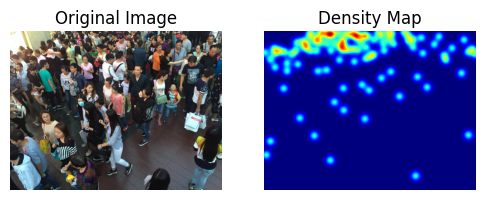

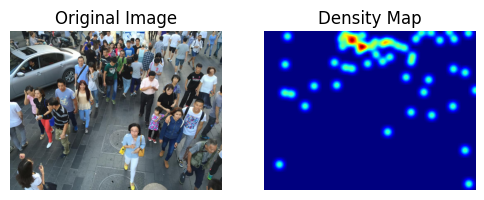

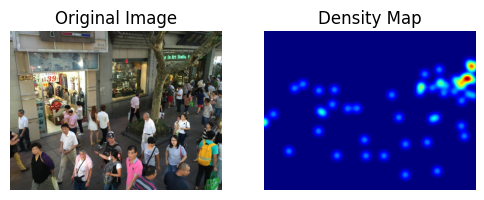

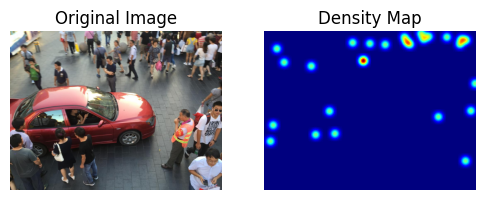

In [15]:
import matplotlib.pyplot as plt

images, density_maps = train_gen[0]

for i in range(len(images)):
    plt.figure(figsize=(6, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(images[i].astype('uint8'))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(density_maps[i].squeeze(), cmap='jet')
    plt.title('Density Map')
    plt.axis('off')

    plt.show()

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Multiply, Subtract

def VGG16_Block5_Transpose_DRU(input_shape=(768, 1024, 3)):
    inputs = Input(shape=input_shape)

    # Load pretrained VGG16
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    block5_output = base_model.get_layer("block5_pool").output  # (24, 32, 512)

    # 1x1 conv (reduce channels to 64)
    x = Conv2D(64, (1, 1), activation='relu', padding='same')(block5_output)

    # Upsample: (24, 32) → (48, 64)
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)

    # Upsample: (48, 64) → (96, 128)
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)

    # 🔁 Additional upsampling to reach (768, 1024)
    for _ in range(3):  # 96→192→384→768
        x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
        x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)

    output_DRU = x  # (768, 1024, 64)

    # DRU Convs
    dru_conv = Conv2D(32, (1, 1), activation='relu', padding='same')(output_DRU)
    dru_conv = Conv2D(32, (3, 3), activation='relu', padding='same')(dru_conv)
    dru_conv = Conv2D(1, (3, 3), activation='relu', padding='same')(dru_conv)

    # Project to 1 channel
    projected_dru = Conv2D(1, (1, 1), padding='same')(output_DRU)

    # Final DRU operation
    multiplied = Multiply()([projected_dru, dru_conv])
    final_output = Subtract()([projected_dru, multiplied])

    model = Model(inputs=inputs, outputs=final_output)
    return model

In [17]:
from tensorflow.keras.optimizers import Adam

model = VGG16_Block5_Transpose_DRU()

model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='mse',
    metrics=['mae']
)

In [18]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Save to Drive
checkpoint_path = '/kaggle/working/best_model_2.h5'

callbacks = [
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
)

Epoch 1/30


I0000 00:00:1750095419.311354      89 service.cc:148] XLA service 0x7da6bc0023f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750095419.314143      89 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750095419.314170      89 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750095420.538564      89 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1750095422.585184      89 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750095422.754805      89 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750095426.903794      89 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 8.5199e-06 - mae: 0.0014

E0000 00:00:1750095665.893218      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750095666.066070      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750095669.917234      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750095670.217548      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-16 17:41:11.352169: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[4,64,768,1024]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,768,1024]{3,2,1,0}, f32[6

90/90 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - loss: 8.4521e-06 - mae: 0.0014 - val_loss: 1.3485e-07 - val_mae: 2.0504e-04
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - loss: 3.2695e-07 - mae: 2.4528e-04 - val_loss: 1.2199e-07 - val_mae: 1.9513e-04
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - loss: 2.6915e-07 - mae: 2.2173e-04 - val_loss: 1.1363e-07 - val_mae: 1.7960e-04
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - loss: 2.7069e-07 - mae: 2.1411e-04 - val_loss: 1.0326e-07 - val_mae: 1.6263e-04
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - loss: 2.6606e-07 - mae: 1.9091e-04 - val_loss: 9.2360e-08 - val_mae: 1.4445e-04
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - loss: 2.1483e-07 - mae: 1.7311e-04 - val_loss: 8.4284e-08 - val_mae: 1.4554e-04
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - loss: 2.2221e-07 - mae: 1.7422e-04 - val_loss: 7.7986e-08 - val_mae: 1.1409e-04
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - loss: 1.7432e-07 - mae: 1.5655e

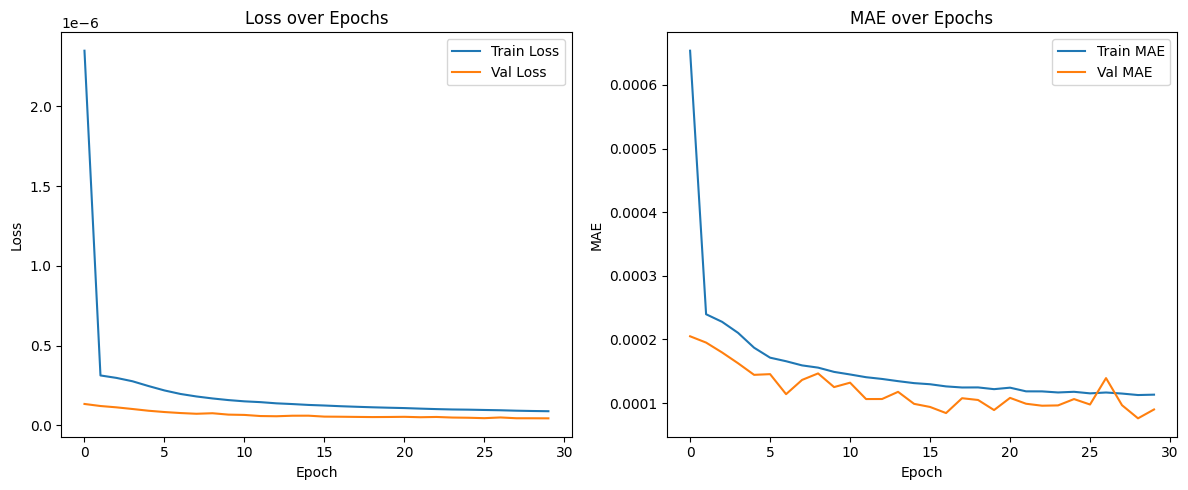

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE (only if you're tracking it)
if 'mae' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('MAE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# 📥 Load the previously trained model
model = load_model('/kaggle/input/crowd-count/keras/default/1', compile=True)

# ✅ Checkpoint to overwrite the same file
checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_2.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# 🧠 Reduce LR on plateau
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# 🛑 Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

# 🏋️ Continue training for 20 more epochs
model.fit(
    train_gen,                # your training generator
    validation_data=val_gen,  # your validation generator
    epochs=50,                      # total epochs (set > current epoch)
    initial_epoch=30,              # start from where you left off
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)

ValueError: File format not supported: filepath=/kaggle/input/crowd-count/keras/default/1. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/kaggle/input/crowd-count/keras/default/1, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [32]:
# 👇 Create test generator (no shuffling)
test_gen = ImageDensityMapGenerator(
    image_dir='/kaggle/input/crowd-data/crowd dataset/test_data/images',
    density_dir='/kaggle/input/test-data-density-map',
    image_size=(768, 1024),
    batch_size=1,
    shuffle=False
)

# 🔮 Predict density maps
predictions = model.predict(test_gen, verbose=1)

# 📏 Calculate MAE on total count per image
mae_total_count = 0.0
n_samples = len(test_gen)

for i in range(n_samples):
    # True density map
    _, true_density = test_gen[i]
    true_count = np.sum(true_density)

    # Predicted density map
    pred_density = predictions[i]
    pred_count = np.sum(pred_density)

    # Accumulate MAE
    mae_total_count += abs(pred_count - true_count)

# ✅ Final MAE
mae_total_count /= n_samples
print(f"📊 Test MAE (Total Count): {mae_total_count:.2f}")

316/316 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step
📊 Test MAE (Total Count): 16.66


In [28]:
import numpy as np

# 👇 Create test generator (no shuffling)
trainn_gen = ImageDensityMapGenerator(
    image_dir='/kaggle/input/crowd-data/crowd dataset/train_data/images',
    density_dir='/kaggle/working/ground_truth_density_map',
    image_size=(768, 1024),
    batch_size=1,
    shuffle=False
)

predictions = model.predict(trainn_gen, verbose=1)

# 📏 Initialize MAE and MSE accumulators
mae_total_count = 0.0
mse_total_count = 0.0
n_samples = len(trainn_gen)

for i in range(n_samples):
    # True density map
    _, true_density = trainn_gen[i]
    true_count = np.sum(true_density)

    # Predicted density map
    pred_density = predictions[i]
    pred_count = np.sum(pred_density)

    # Accumulate MAE and MSE
    error = pred_count - true_count
    mae_total_count += abs(error)
    mse_total_count += error ** 2

# ✅ Final MAE, MSE, RMSE
mae_total_count /= n_samples
mse_total_count /= n_samples
rmse_total_count = np.sqrt(mse_total_count)

print(f"📊 Train MAE (Total Count): {mae_total_count:.2f}")
print(f"📊 Train RMSE (Total Count): {rmse_total_count:.2f}")

400/400 ━━━━━━━━━━━━━━━━━━━━ 46s 116ms/step
📊 Train MAE (Total Count): 16.19
📊 Train RMSE (Total Count): 21.57
